In [1]:
%matplotlib inline

In [3]:
import numpy as np
import scipy as sp
import tomopy
import astra
import numba
import dask
import pylab as plt

In [10]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [6]:
test_object = tomopy.misc.phantom.shepp2d(512)
test_object = np.squeeze(test_object)

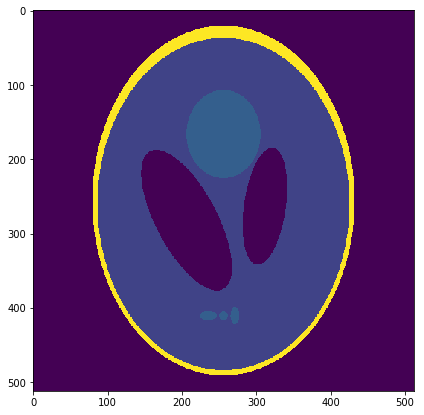

In [8]:
plt.figure(figsize=(7,7))
plt.imshow(test_object)
plt.show()

In [92]:
def build_reconstruction_geomety(detector_size, angles):
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)
    return proj_geom

def astra_tomo2d(sinogram, angles):
#     angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')

    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
#     cfg['option']['ShortScan'] = True
#     cfg['option']['MinConstraint'] = 0
#     cfg['option']['MaxConstraint'] = 0.02

#     FOR CPU version
#     proj_id = astra.create_projector('linear', proj_geom, vol_geom)
#     cfg['ProjectorId']= proj_id;
    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_build_sinogram(rec, angles):
#     angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = rec.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    sinogram_id, sinogram = astra.create_sino(rec, proj_id)
    
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return sinogram

def zero_pad_sinogram(sinogram):
    res = np.zeros(shape=(sinogram.shape[0], 2 * sinogram.shape[1]), dtype=sinogram.dtype)
    res[:, sinogram.shape[1]//2:sinogram.shape[1]//2 + sinogram.shape[1]] = sinogram
    return res

def unpad_rec(rec, sinogram):
    res = np.zeros(shape=(sinogram.shape[1], sinogram.shape[1]), dtype=rec.dtype)
    res = rec[sinogram.shape[1]//2:sinogram.shape[1]//2 + sinogram.shape[1],
              sinogram.shape[1]//2:sinogram.shape[1]//2 + sinogram.shape[1]]
    return res

def reconstruct_with_padding(sinogram, angles):
    tmp_sinogram = zero_pad_sinogram(sinogram)
    rec, proj_geom, cfg = astra_tomo2d(tmp_sinogram, angles)
    rec = unpad_rec(rec, sinogram)
    return rec

In [87]:
angles = np.linspace(0,180,512, endpoint=False)*np.pi/180

In [88]:
test_sinogram = astra_build_sinogram(test_object, angles)

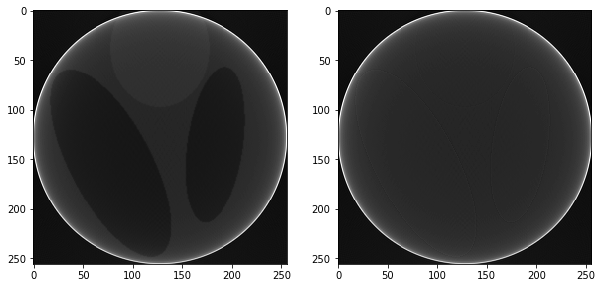

In [96]:
rec = reconstruct_with_padding(test_sinogram[:,128:-128], angles)

plt.figure(figsize=(10,15))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.subplot(121)
plt.imshow(rec, interpolation='nearest', cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(rec-test_object[128:-128,128:-128], interpolation='nearest', cmap=plt.cm.gray)

plt.show()

In [81]:
test_sinogram.shape

(512, 512)